# News Aggregation Natural Language Processing*

In this notebook, we'll be extending our understanding of sequence-based modeling by extracting sentiments and signals from real-world text data provided by [Kaggle](https://www.kaggle.com/rmisra/news-category-dataset).

Specifically, we'll be applying LSTM networks against corpuses of news articles from the year 2012 to 2018 obtained from HuffPost and attempting to determine whether each article is political or non-political from specific headlines!

#### *Developer's Note:
*The original intent of this project was to create an NLP model that could determine the original category for each article given as input; however due to inaccuracy errors with the model, I've decided to boil down the capabilities of the model to a "one vs. many" classifier: instead of trying to determine whether the article was ENTERTAIMENT, POLITICAL, SPORTS, etc. it's been simplified to either POLITICAL or NON-POLITICAL (because that's all that really matters).  There will be a few cells in this project that will document what went wrong when pursuing the original intent as well as the changes that have been made to create a more accurate, more useful model.*

#### 🔹 General Importations

Let's get started by including all the general imports we're using for this project.

In [1]:
# General Data Science Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Regular Expression Parsing and Word Cloud Mapping
import re, wordcloud

# Natural Language Toolkit
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download("stopwords")
nltk.download("wordnet")

# Language Token Processing and Frequency Distribution Calculator
from textblob import Word
from collections import Counter

# Generalized Machine/Deep Learning Codependencies
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow for Deep Learning
import tensorflow as tf

[nltk_data] Downloading package stopwords to /Users/Temp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Temp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 🔹 Deep Learning Functional Initializations

As good practice, let's initialize the specific tools we'll be using from `TensorFlow` to make things a little more readable moving forward.

In [2]:
# Stopwords: Generally Recognized Noisy Terms
STOPWORDS = nltk.corpus.stopwords

# Sequential Model Architecture
Sequential = tf.keras.models.Sequential

# Connective Layers with Dropout
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Early Stopping Optimization
EarlyStopping = tf.keras.callbacks.EarlyStopping

# Natural Text-Based Language Processing Layers with RNN
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
SpatialDropout1D = tf.keras.layers.SpatialDropout1D

# Language Tokenization Filter
Tokenizer = tf.keras.preprocessing.text.Tokenizer

# Padding Function for Dataset Ingestion Preprocessing
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

#### 🔹 Data Loading and Preprocessing

Let's first load and take a look at what data we're working with. 

In [3]:
CORPUS = "../dataset/News_Category_Dataset_v2.csv"

dataset = pd.read_csv(CORPUS, error_bad_lines=False)
# removing entries with null values
dataset = dataset.dropna()
dataset.info()
print('------------------------------')
print('Number of unique categories')
print(dataset['category'].nunique())
print('------------------------------')
print('List of unique categories')
print(dataset['category'].unique())
print('------------------------------')
print('Number of articles per category')
print(dataset['category'].value_counts())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 148983 entries, 0 to 200848
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           148983 non-null  object
 1   headline           148983 non-null  object
 2   authors            148983 non-null  object
 3   link               148983 non-null  object
 4   short_description  148983 non-null  object
 5   date               148983 non-null  object
dtypes: object(6)
memory usage: 8.0+ MB
------------------------------
Number of unique categories
41
------------------------------
List of unique categories
['CRIME' 'ENTERTAINMENT' 'IMPACT' 'POLITICS' 'WEIRD NEWS' 'WORLD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'LATINO VOICES' 'SCIENCE' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'

Our dataset is huge!  We have 148,983 different news articles and 41 different categories, not to mention the number of articles per category is extremely disparate!

To create an unbiased model that won't take multiple hours to run, we'll simply our dataset by taking out some of the categories as well as utilizing undersampling to randomly remove entries form the catagories that have way more articles than other catagories.*

In [4]:
# # Taking out categories
# df = dataset[dataset['category'].isin(['POLITICS','WELLNESS','ENTERTAINMENT','TRAVEL','STYLE & BEAUTY','PARENTING',
#                         'HEALTHY LIVING','QUEER VOICES','FOOD & DRINK','BUSINESS','COMEDY','PARENTS','SPORTS'])]

# # Making the catagories even
# count = 0
# df_classes = []

# # loop through every category in our dataset
# for category in df['category'].unique():
    
#     df_class = df[df['category'] == category]
    
#     df_class_under = df_class.sample(3445) # we equalize the catagories to have the same amount of entries
#     df_classes.append(df_class_under)
#     count+=1
    
# short_df = pd.concat(df_classes, axis=0)
# short_df = short_df.sort_index()

#### *Developer's Note:

*Because we've shifted our intent from a multiclass-classification model into "one to many" classfication, the process of preparing our data will be a little bit different.  Instead of taking out categories and making every category even, I can include every category in our dataset and make each one of those categories even except our "POLITICS" category.  This is because I'm going to add up every single category other than the "POLITICS" category to create the "NON-POLITICS" category.*

In [5]:
# Creating the non-politics set of data
count = 0
df_classes = []

# loop through every category in our dataset
for category in dataset['category'].unique():
    
    if category != "POLITICS":
        df_class = dataset[dataset['category'] == category]
        df_class_under = df_class.sample(651) # we equalize the catagories to have the same amount of entries
        df_classes.append(df_class_under)
    elif category == "POLITICS": 
        df_class = dataset[dataset['category'] == category]
        df_classes.append(df_class)
        
    count+=1
    
short_df = pd.concat(df_classes, axis=0)
short_df = short_df.sort_index()

Once we have our datasets all evened out, we can seperate them into the "POLITICS" category and our "NON-POLITICS" category utilizing this helper function below.

In [6]:
def create_sentiments(data):
  """ Function to create new features across data to track sentiment. """
  if data["category"] == "POLITICS":
    return str("POLITICS")
  elif data["category"] != "POLITICS":
    return str("NON-POLITICS")

In [7]:
short_df["sentiment"] = short_df.apply(create_sentiments, axis=1)

In [8]:
print('------------------------------')
print('Number of unique categories')
print(short_df['sentiment'].nunique())
print('------------------------------')
print('List of unique categories')
print(short_df['sentiment'].unique())
print('------------------------------')
print('Number of articles per category')
print(short_df['sentiment'].value_counts())

------------------------------
Number of unique categories
2
------------------------------
List of unique categories
['NON-POLITICS' 'POLITICS']
------------------------------
Number of articles per category
POLITICS        26913
NON-POLITICS    26040
Name: sentiment, dtype: int64


#### *Developer's Note:

*As it can be seen above, our datasets are now simplified to our two distinct categories with each being roughly equal to the other.*

That's much better.  Our dataset is now much simpler to work with.

Now that we got that out of the way, we now only need to track headlines and categories to perform our dataset investigation.  Therefore, let's drop everything else and verify that our data integrity is as good as it can be (a.k.a no null values).

In [9]:
FEATURES_IMPUTED = ["headline", "sentiment"]

processed = short_df[FEATURES_IMPUTED]
processed.isnull().sum()

headline     0
sentiment    0
dtype: int64

---

#### 🔹 Language Processing for Data Ingestion

First thing to do now that we have our dataset extracted is to clean up as much erroneous information from our headline data in order to make our patterns and target labels as explicit and non-noisy as possible

These antipatterns include the following:
- Variances in syntactic capitalization.
- Symbols and other non-alphanumeric cases.
- Non-signal-related digits and numbers.
- **Stop Words**: generally noisy terms and tokens. 
- Different inflections of words that could be interpreted differently.

We'll create a helper function to prevent all of these antipatterns from getting into our model's input data in one fell swoop.

In [10]:
def clean_corpus(data, stopwords, dtype="frame", feature="verified_reviews"):
  """ Function to remove special characters, digits, stop words, 
  unimportant symbols, and other unnecessary noise from our dataset. """
  if dtype == "frame":
    data[feature] = data[feature].apply(
        lambda review: " ".join(review.lower() for review in review.split())
    )
    data[feature] = data[feature].str.replace(
        r"[^A-Za-z0-9 ]", r"",
        regex=True
    )
    data[feature] = data[feature].str.replace(
        "\d+", ""
    )
    data[feature] = data[feature].apply(
        lambda token: " ".join(token for token in token.split() if token not in stopwords)
    )
    data[feature] = data[feature].apply(
        lambda token: " ".join([Word(token).lemmatize() for token in token.split()])
    )
  elif dtype == "list":
    data = [" ".join(review.lower() for review in review.split()) for review in data]
    data = [re.sub(r"[^A-Za-z0-9 ]", r"", review) for review in data]
    data = [re.sub("\d+", "", review) for review in data]
    data = [" ".join(token for token in token.split() if token not in stopwords) for token in data]
    data = [" ".join([Word(token).lemmatize() for token in token.split()]) for token in data]
  return data

With our helper function complete, we can apply it to our processed dataset and clean it up.

In [11]:
stopwords = STOPWORDS.words("english")

processed = clean_corpus(data=processed, 
                         stopwords=stopwords,
                         dtype="frame",
                         feature="headline")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change fr

In [12]:
processed.head(5)

,headline,sentiment
5,morgan freeman devastated sexual harassment cl...,NON-POLITICS
12,way life risk remote oystergrowing region call...,NON-POLITICS
13,trump crackdown immigrant parent put kid alrea...,POLITICS
14,trump son concerned fbi obtained wiretap putin...,POLITICS
15,edward snowden there one trump love vladimir p...,POLITICS


As we can see from above, our dataset will now only contain signal-expressive term as well as their corresponding category.

Before we get to modeling, however, let's do some more sanity checks and peek into what the model thinks about our dataset.

First thing we'll do is create a word cloud: a visualized format of conceptualizing the most frequent term occurrences in our headlines to better understand our tokenized distribution.

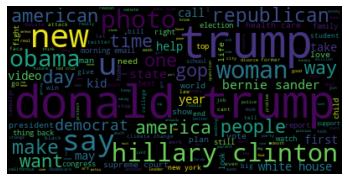

In [44]:
common_words = str()

for headline in processed["headline"]:
  headline = str(headline)
  tokens = headline.split()
  common_words += " ".join(tokens) + " "
frequencies = wordcloud.WordCloud().generate(common_words)
plt.imshow(frequencies, interpolation="bilinear")
plt.axis("off")
plt.show()

We can even generate word clouds for each specific target category and conceptualize the most frequent term occurrence in each category.

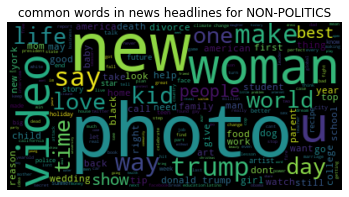

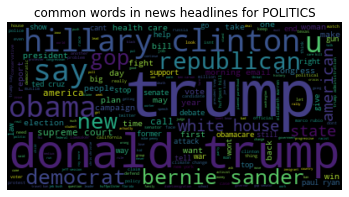

In [48]:
for sentiment in short_df['sentiment'].unique():
    common_words = str()

    for headline in processed[short_df["sentiment"]==sentiment]['headline']:
      headline = str(headline)
      tokens = headline.split()
      common_words += " ".join(tokens) + " "
    frequencies = wordcloud.WordCloud().generate(common_words)
    plt.imshow(frequencies, interpolation="bilinear")
    plt.axis("off")
    plt.title("common words in news headlines for " + sentiment)
    plt.show()

As we move on, we need to ready our processed data in a way for our machine to understand them.  As it stands, our machine cannot comprehend what "POLITICS" means or any other category for that matter, however we can use a **label encoder** to properly vectorize our target categories.

In [15]:
label_encoder = LabelEncoder()
processed["sentiment"] = label_encoder.fit_transform(
    processed["sentiment"]
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
processed.head(5)

,headline,sentiment
5,morgan freeman devastated sexual harassment cl...,0
12,way life risk remote oystergrowing region call...,0
13,trump crackdown immigrant parent put kid alrea...,1
14,trump son concerned fbi obtained wiretap putin...,1
15,edward snowden there one trump love vladimir p...,1


Superb!  Now that our categories are properly tokenized and ready for data ingestion, we can do the same for our actual input data: the headlines.  For that, we'll use a `tokenizer` object provided by `NLTK`.

In [17]:
def tokenize_dataset(tokenizer, data):
  """ Function to tokenize input data for model training/testing. """
  return pad_sequences(tokenizer.texts_to_sequences(data))

In [18]:
tokenizer = Tokenizer(num_words=500, split=" ")
tokenizer.fit_on_texts(processed["headline"].values)

X = tokenize_dataset(tokenizer, processed["headline"].values)

In [19]:
X

array([[  0,   0,   0, ..., 495, 127,  32],
       [  0,   0,   0, ...,   0,  28,  44],
       [  0,   0,   0, ..., 179, 281,  61],
       ...,
       [  0,   0,   0, ...,   0,  24,   9],
       [  0,   0,   0, ...,  90, 396, 250],
       [  0,   0,   0, ...,   0, 108, 232]], dtype=int32)

We can see from above that our data has been properly tokenized and now all our text-based headlines have been transformed into digestible, frequency-based models for our machine to train with.

Last but not least, we'll setup our target labels to be ingestible as well and perfrom our train-test-splitting to generate the datasets that our model will train-test with.

In [20]:
y = pd.get_dummies(processed["sentiment"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=42)

---

#### 🔹 Data Ingestion and Predictive Modeling

It's finally time to setup our model.

We'll be designing a sequenced-based learning model to extract our vectorized text data which, in this case, involves using a **long short-term memory** model which is simply a higher-order recurrent neural network.  This will be used to properly ingest and retain signal comprehension across our data.

Specifically, we'll use the following layer specifications:
- An **Embedding** layer to properly vectorize our term inputs for signal extraction.
- A **Spatial Dropout** layer that effectively performs dropout regularization on vectorized text data that prevents overfitting.
- Two **LSTMs** in sequence to extract more internal heuristics. (These models are preinitialized with dropout regularization.)
- A **Dense** (connective-predictive) layer to get our output classification.

In [22]:
# Embedding Layer for Token-Specific Vectorization
input_embedding_layer = Embedding(500, 120, input_length=X.shape[1])

# Dropout Regularizer for Text Embedding
embedding_dropout_layer = SpatialDropout1D(0.4)

# First Recurrent LSTM Cellular Architecture
first_recurrent_layer = LSTM(176, 
                             dropout=0.2, 
                             recurrent_dropout=0.2, 
                             return_sequences=True)

# Second Recurrent LSTM Cellular Architecture
second_recurrent_layer = LSTM(176, 
                              dropout=0.2, 
                              recurrent_dropout=0.2)

# Final Dense Layer for Output Extraction*
output_connective_layer = Dense(2, activation="softmax")

2021-10-07 21:59:06.934588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### *Developer's Note: 
*I had actually tried using the softmax activation function for my output_connective_layer however it seemed to be overfitting my model to the very first label it encountered during training.  This might be because the Softmax regression normalizes our input values into a vector of values that follows a probability distribution whose total sums up to 1, we can assume that our model was reaching a sum total of 1 as soon as possible within our first training entry therefore resulting in a model that was overfitted on the first training label it encountered.*

*Update: After trying every possible activation function, softmax seemed to be the only one that worked with average success. Tanh fundamentally failed as the model predicted only label 0 or label 10 for every training choice while relu crashed the model after epoch 3. For every activation function that wasn't similar to softmax, the accuracy rating reached 0.08 at best after 10 epochs. Changes in optimizer and loss functions did not affect model's abnormal performance.*

Now that we've streamlined our model architecture with appropriate layering, we can put it all together and construct our model.

In [23]:
# Sequential Model Architecture Design
model = Sequential()

# Add All Initialized Layers in Effective Sequence
model.add(input_embedding_layer)
model.add(embedding_dropout_layer)
model.add(first_recurrent_layer)
model.add(second_recurrent_layer)
model.add(output_connective_layer)

# Get Model Summary for Confirmation
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 120)           60000     
_________________________________________________________________
spatial_dropout1d (SpatialD  (None, 13, 120)           0         
ropout1D)                                                        
_________________________________________________________________
lstm (LSTM)                  (None, 13, 176)           209088    
_________________________________________________________________
lstm_1 (LSTM)                (None, 176)               248512    
_________________________________________________________________
dense (Dense)                (None, 2)                 354       
_________________________________________________________________
Total params: 517,954
Trainable params: 517,954
Non-trainable params: 0
__________________________________________________

Next, we'll compile our model with appropriate loss functions, optimizers, and accuracy extraction metrics.

We'll be using categorical cross-entropy as our loss function and a boosted form of Adam optimization called Nesterov-Boosted Adam, or Nadam, to get optimal model results.

In [24]:
# Compile Model with Specified Loss and Optimization Functions
model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

We'll initialize some final fitness parameters, including our batch size for gradient descent optimization and our total epochs for runtime.

In [49]:
# Define Batch Size and Epochs as Hyperparameters
batch_size, epochs = 32, 10

That's it! We're ready for model fitness!

Here we fit our data to our training sets using our configured model and initialized hyperparameters!

In [26]:
# Fit Learning Model Using Training Data and Configured Hyperparameters
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback],
                    verbose=True)

Epoch 1/10
1159/1159 [==============================] - 49s 39ms/step - loss: 0.4342 - accuracy: 0.8062
Epoch 2/10
1159/1159 [==============================] - 45s 39ms/step - loss: 0.4043 - accuracy: 0.8267
Epoch 3/10
1159/1159 [==============================] - 45s 38ms/step - loss: 0.3969 - accuracy: 0.8279
Epoch 4/10
1159/1159 [==============================] - 218s 189ms/step - loss: 0.3894 - accuracy: 0.8308
Epoch 5/10
1159/1159 [==============================] - 45s 39ms/step - loss: 0.3848 - accuracy: 0.8334
Epoch 6/10
1159/1159 [==============================] - 46s 40ms/step - loss: 0.3795 - accuracy: 0.8347
Epoch 7/10
1159/1159 [==============================] - 45s 39ms/step - loss: 0.3763 - accuracy: 0.8358
Epoch 8/10
1159/1159 [==============================] - 47s 41ms/step - loss: 0.3739 - accuracy: 0.8368
Epoch 9/10
1159/1159 [==============================] - 48s 41ms/step - loss: 0.3715 - accuracy: 0.8395
Epoch 10/10
1159/1159 [==============================] - 47s 4

And to conclude our model training/testing step, we perform our basic testing: evaluating our model using our testing data holdouts!

In [33]:
# Evaluate Learned Model Using Testing Data
model.evaluate(X_test, y_test)

497/497 [==============================] - 3s 6ms/step - loss: 0.4023 - accuracy: 0.8246


[0.4022662341594696, 0.8246254324913025]

For extra data visualization, we'll create a **confusion matrix** to show how accurately we performed for our discrete predictions.

We'll use a helper function as well to clearly model our correct and incorrect predictions.

In [34]:
# Get Our Predicted Labels
y_pred = pd.DataFrame(data=model.predict(X_test), columns=[0,1])
y_pred = y_pred.apply(round, axis=1).astype(int)

In [35]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test.values.argmax(axis=1), 
                        y_pred=y_pred.values.argmax(axis=1))

In [36]:
def cmat_(cm, labels=None):
  """ Helper function to visualize confusion matrices. """
  ax = plt.subplot()
#   sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.heatmap(cm, annot=True, fmt="g", cmap="YlGnBu", linewidths=0.5, ax=ax)
  
  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")
  
  if labels.all():
      ax.set_xticklabels(labels)
      ax.set_yticklabels(labels)
    
  plt.show()

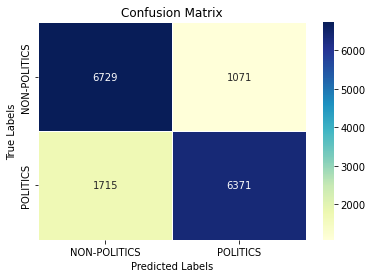

In [37]:
# Render Confusion Matrix as Seaborn Heatmap Visualization*
cmat_(cmat, short_df['sentiment'].unique())

#### Developer's Note
*This is where the initial intent broke down.  The Confusion Matrix would show that the model always overpredicts on label 0 no matter what.  The model did the same thing back when the ENTERTAINMENT label existed (the previous label 0)*

Our second additional visualization will be that of a **classification report** to clearly display precision, recall, accuracy, and F1 metrics across all labels and for our dataset overall.

In [38]:
# Create Classification Report with Summary Statistics/Metrics
print(classification_report(y_true=y_test.values.argmax(axis=1),
                            y_pred=y_pred.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      7800
           1       0.86      0.79      0.82      8086

    accuracy                           0.82     15886
   macro avg       0.83      0.83      0.82     15886
weighted avg       0.83      0.82      0.82     15886



Our report shows that our model performed alright on both determining political and non-political headlines.